# Explainable AI
## Why need Explainable AI?
This notebook will discuss the idea of explainable AI (XAI) in applying machine learning to signals or acoustics. How does XAI work and why need it? Suppose two cases, 1) you have created a model that requires a lot of inputs with near-perfect accuracy, and/or 2) you have made a new model with poor accuracy but uses similar inputs to the last model. What's the difference between the two models? Why does one model perform better than another and how can we explain this? This has been an interesting question in machine learning because many consider machine learning a black box diagram where the model handles the intricacies of data processing to derive a solution. Although the methods provide adequate and robust results, how are the models learning and how do we gain an understanding from the trained models? This is where XAI comes into discussion. The idea behind XAI is to open up the black box and begin investigating why particular features provide adequate information to predict an output or to begin understanding the role that inputs have with each other. By investigating these roles, we can learn from the data and create new insights into our research. From traditional statistical metrics to more complex analytical evaluations of a trained model, we can start to comprehend how models come to solutions and trust the output of these models. While there are several popular approaches to XAI, we will focus on only a few examples for brevity. In particular, we will go through approaches for interpreting model prediction for unsupervised and supervised models. This will be demonstrated through.

<u>Unsupervised</u>:
1) Feature Visualization
2) Elbow Curve
3) Silhouette Score
4) Davies-Bouldin Index

<u>Supervised</u>:

1) Shapley Additive exPlanations (SHAP)
2) Local Interpretable Model-Agnostic Explanations (LIME)
3) Permutation Importance
4) Saliency Maps

While we have split the topics into unsupervised and supervised techniques, the approaches discussed below are not particular to any scenario and can be used vice versa. It should be noted that while the techniques discussed above are particular for features and their impact on output, further investigation into how a machine learning model utilizes the features (i.e. using Bayes theorem, identifying boundaries, etc.) to make decisions should be considered when investigating machine learning models. For example, a support vector machine model may work well when the data is highly separable in feature space but may fall short in its predictions when it needs something more complex.

By: Ryan McCarthy

### Load Packages

In [1]:
# Load Packages
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

# Unsupervised Investigation
Unsupervised learning is a great tool to group data into particular classes or investigate large data faster without any known apriori information. Several unsupervised techniques can be used such as k-means clustering, fuzzy clustering, gaussian mixture models, hierarchical clustering, and Density-Based Spatial Clustering (DBSCAN). These models provide relatively quick clustering of the data based on the features of the samples and their proximity to each other. When defining these features, the dimensionality can make the interpretation of the results, the number of clusters, why clusters are created, or how to evaluate the clusters difficult to understand. Below we demonstrate a few approaches to better interpreting the model prediction and ways to evaluate the cluster's prediction.

We will start by loading in a ~60-second recording of a humpback whale song near Glacier Bay, details [here](https://librosa.org/doc/main/recordings.html). This recording will give us a chance to apply and evaluate unsupervised learning techniques.

In [2]:
y,sr = librosa.load(librosa.ex('humpback'))

# Play audio file
ipd.Audio(data=y,rate = sr)

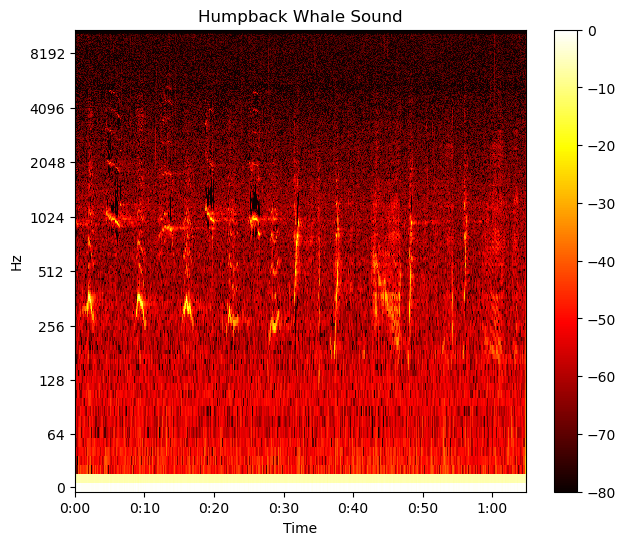

In [3]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'hot')
plt.colorbar();
plt.title('Humpback Whale Sound')
plt.show()

Above we see the spectrogram of the Fast Fourier Transform (FFT). We can see that the song is primarily contained within 128-4096 Hz. Although we could manually identify the sounds and similarities in the spectra, we will turn to unsupervised learning to identify clusters. To do this, we will first split the data into segments using the code below before using feature extraction and applying unsupervised clustering.

In [4]:
# Function to split the data
def split(a, n):
    data = []
    for m in range(n,len(a),n):
        data.append(a[m-n:m])
    return data

In [5]:
# Pull out samples
data = split(y,sr//2)
data = np.vstack(data)

### Feature Extraction
We will use the feature extraction approach RandOm Convolutional KErnel Transform (ROCKET). ROCKET creates convolutional kernels of random length and dilation to transform the time series (segments). Two features are then extracted from the convolved segments, namely the proportion of positive values and the global max. Through this unique random convolution approach, we can identify key features that may be useful for clustering without prior knowledge. 

In [6]:
from pyts.transformation import ROCKET

In [7]:
# ROCKET transformation (feature extraction)
rocket = ROCKET(n_kernels=500, random_state=42)
X_rocket = rocket.fit_transform(data)
print(f"Samples: {X_rocket.shape[0]}")
print(f"Features: {X_rocket.shape[1]}")

Samples: 129
Features: 1000


## Feature Visualization Embeddings
Once we have selected a feature extraction method, it will be useful to visualize the separation of the data in the higher dimensions. One way of doing this is through embeddings to reduce the dimensions to something that can be visualized while preserving the spatial distribution of the data and understanding how a model may be clustering the data. In the example above, after applying ROCKET to the individual segments, we notice that the data now has 1000 features. Applying clustering to this new feature space requires the model to consider all of these features simultaneously, this is difficult to visualize and interpret how a model is clustering. Several popular transformations can help visualize the feature space such as principal component analysis (PCA), Isomapping, or t-distributed stochastic neighbor embedding (t-SNE). We will demonstrate a few of these techniques to understand how unsupervised models are clustering below. 

### Principal Component Analysis (PCA)
Principal component analysis (PCA) is a great tool to decompose and visualize data. Details of PCA can be found [here](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) or [here](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html). The PCA takes a data matrix $X$ of dimensions $m$ x $n$ where $m$ is the number of samples and $n$ is the number of features and standardizes the data. After standardization, the covariance matrix is computed for the features. An example of this is seen as:
$$
    \Sigma = \begin{bmatrix}
       \sigma(i,i) & \sigma(j,i) \\\
       \sigma(i,j) & \sigma(j,j)
    \end{bmatrix}
$$
where $\sigma_{i,k} = \frac{1}{n-1}\sum_{i=1}^n(x_{i,j}-\bar{x}_{j})(x_{i,k}-\bar{x}_{k})$ and $\bar{x}$ is the mean vector. The data  decomposes into:
$$
    X = U\Sigma V^T
$$
$U$ is the left singular vectors and $V$ is the right singular vectors. The new feature space is created using:
$$
    A = \Sigma V^T
$$
where the number of columns of A is the number of components that can be used to reconstruct the original matrix $X$. The resulting PCA of the feature space of the segments is shown below.

In [8]:
from sklearn.decomposition import PCA

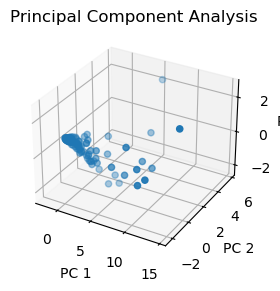

In [9]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pcavis = pca.fit_transform(X=X_rocket)
ax.scatter(pcavis[:,0],pcavis[:,1],pcavis[:,2])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Principal Component Analysis')
plt.show()

### Multidimensional Scaling (MDS)
Multidimensional Scaling (MDS) is an algorithm that seeks to find a lower-order representation of the data that preserves the distances between points. In this notebook, we will look at the classical MDS approach which models the similarity or dissimilarity of data as distances in a geometric space. A distance matrix $D$ is constructed by calculating some distance metric for sample points i and j as:
$$
    d_{i,j} = ||x_i-x_j||_2
$$
The above distance metric is for Euclidean distance. The algorithm looks to compute a a centered inner-product matrix B by using:
$$
    B = -\frac{1}{2}H(D\odot D)H
$$
where $\odot$ is the Hadamard product of two matrices, and $H = I - \frac{1}{n}J$ where I is the identity matrix and J is a matrix of all ones. We can then find a solution by the eigendecomposition of B using:
$$
    P = \Lambda^{1/2}V'
$$
where $E$ is the matrix of eignevectors, $\Lambda$ is the diagonal matrix of eigenvalues of B, and $B = V\Lambda V'$. We show this transformation below.

In [10]:
from sklearn.manifold import MDS

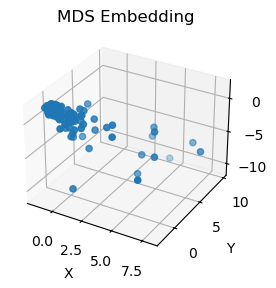

In [11]:
mds = MDS(n_components=3)
X_mds = mds.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_mds[:,0],X_mds[:,1],X_mds[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('MDS Embedding')
plt.show()

### Isomapping
One of the original manifold approaches is the Isometric Mapping algorithm. Details of this approach can be found [here](https://www.science.org/doi/10.1126/science.290.5500.2319). This approach has three main steps:
1) Construct a neighborhood graph on a manifold M using a distance matrix between pairs of points. This is done either through a K-nearest neighbors approach or a fixed radius.
2) Estimate the distances between the pairs of points within M by computing the shortest distances.
3) Apply a multidimensional scaling (MDS) embedding of the graph distances that preserves the geometry of the manifold.
In the example below, we usethe  10 nearest neighbors and extract 3 components. 

In [12]:
from sklearn.manifold import Isomap

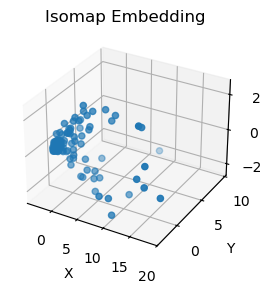

In [13]:
isomap = Isomap(n_neighbors=10, n_components=3)
X_isomap = isomap.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_isomap[:,0],X_isomap[:,1],X_isomap[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Isomap Embedding')
plt.show()

### t-distributed stochastic neighbor embedding (t-SNE) 
t-distributed stochastic neighbor embedding (t-SNE) is a method for visualizing high dimensional data through a nonlinear dimensionality reduction technique. Details of this algorithm can be found [here](https://medium.com/swlh/t-sne-explained-math-and-intuition-94599ab164cf) This is done by first calculating the conditional probability of points next to each other by a Gaussian with mean centered at a point with a standard deviation. This is written as:
$$
    p_{j|i} = \frac{e^{-||x_i-x_j||^2/2\sigma_i^2}}{\sum_{k\neq i}e^{-||x_i-x_k||^2/2\sigma_i^2}}
$$
where $x_i$ and $x_j$ are data points in the feature space and $\sigma_i$ is the variance of the Gaussian that is centered at datapoint $x_i$. we can use the conditional probability to calculate the joint probability distribution as:
$$
    p_{i,j} = \frac{p_{j|i}+p_{i|j}}{2n}
$$
where n is the number of points. The algorithm desires to find a mapping that reflects the similarities in $p_{i,j}$ defined as:
$$
    q_{i,j} = \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}(1+||y_k-y_l||^2)^{-1}}
$$
where $y$ is the d-dimensional map points. Locations of $y$ are determined by minimizing the Kullback-Leibler divergence of $p$ and $q$ as: 
$$
    KL(P||Q) = \sum_i\sum_jp_{j,i}\log(\frac{p_{j,i}}{q_{j,i}})
$$
The resulting mapping of the example is shown below. For further information and an example on using t-SNE, please refer to the website [here](https://distill.pub/2016/misread-tsne/).

In [14]:
from sklearn.manifold import TSNE

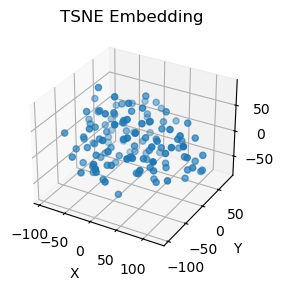

In [15]:
tsne = TSNE(n_components=3,perplexity=20)
X_tsne = tsne.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne[:,0],X_tsne[:,1],X_tsne[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('TSNE Embedding')
plt.show()

### Spectral Embedding
Spectral embedding calculates a non-linear embedding by implementing Laplacian Eigenmaps to find a low-dimensional representation. Details of this method can be found [here](https://ieeexplore.ieee.org/document/6789755). The embedding is done in three steps.
1) The data is transformed into a graph representation using affinity matrix representation.
2) An unnormalized Graph Laplacian is constructed as:

$$
    L = D - W
$$
where $W$ is the weight matrix ($W_{i,j}=e^{-\frac{||X_i-X_j||^2}{t}})$ and $D$ is a diagonal weight matrix consisting of sums of $W$. 

3) Compute eigenvalues and eigenvectors to minimize the objective function using:

$$
    Ly = \lambda Dy
$$
where $\lambda$ are the eigenvalues. The resulting embedding can be seen below.

In [16]:
from sklearn.manifold import SpectralEmbedding

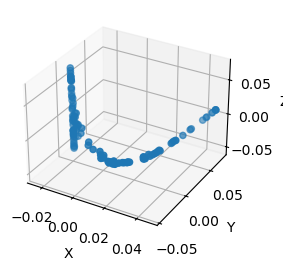

In [17]:
specemb = SpectralEmbedding(n_components=3)
X_specemb = specemb.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_specemb[:,0],X_specemb[:,1],X_specemb[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('')
plt.show()

# Apply Kmeans clustering
K-means clustering is an unsupervised learning algorithm used to cluster data by choosing centroids to minimize the within-cluster sum of squares as:
$$
    \sum_{i=0}^n \min_{\mu_j \in C}(||x_i - \mu_j||^2)
$$
where $C$ is the centroid of a cluster and $\mu$ is the mean. The centroids of the clusters are adjusted and iterated at every step to minimize the within-cluster distance. Points are clustered together based on the minimum distance from the given centroids. Further details are provided [here](https://scikit-learn.org/1.5/modules/clustering.html#k-means).

In [18]:
from sklearn.cluster import KMeans

In [19]:
clusters = range(1, 10)
kmodel = [KMeans(n_clusters=i) for i in clusters]
score = [kmodel[i].fit(X_rocket).inertia_ for i in range(len(kmodel))]

C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

## Visual Interpretation
Using the embeddings defined earlier, we can evaluate a model's unsupervised clustering by looking at the clustering in the new embedded space. For the example below, we will take the Spectral embedding to visualize the data and see how the K-means clustering has grouped the data.

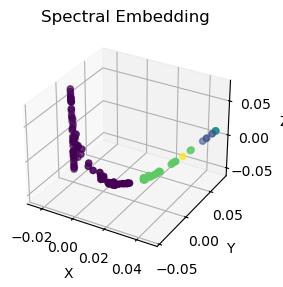

In [20]:
classes = kmodel[4].predict(X_rocket)

specemb = SpectralEmbedding(n_components=3)
X_specemb = specemb.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_specemb[:,0],X_specemb[:,1],X_specemb[:,2],c=classes)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Spectral Embedding')
plt.show()

Colors represent different groupings found by the K-means algorithm. We can see some groups with individual and other samples that could be put into separate groups. This approach helps visualize groupings based on the features.

## Elbow Curve
The elbow curve method is a good method to pick out the number of clusters to use. For unsupervised learning, there are many different methods you could use. One method is the inertia method. This method measures the distance between the samples and its centroid in the feature space, squaring this distance, and summing these squares for each cluster. Finding where the curve flattens out, will tell us how many clusters are optimal to use before it begins to over-cluster.

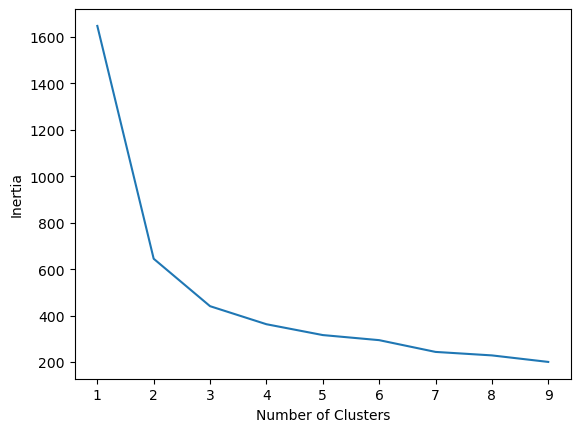

In [21]:
plt.plot(clusters,score)
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.show()

We can see that after 3 clusters, the inertia begins to flatten out potentially meaning that 3 clusters may be optimal for this dataset. 

## Silhouette Score
A silhouette score of 1 indicates that the samples are well separated and the points within clusters are far away from each other. A silhouette score of 0 indicates that the distance between the clusters is not significant and samples are bordering cluster groups. Finally, a negative score indicates that the samples could be assigned to the wrong cluster. The score for silhouette is calculated as:

$$
    silhouette = \frac{b-a}{\max(a,b)}
$$
where $a$ is the average distance between a sample and the other samples in its cluster in feature space and $b$ is the average distance between a sample and the other samples in the neighboring cluster.

In [22]:
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm

For n_clusters = 4 The average silhouette_score is : 0.5103178417601282


C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


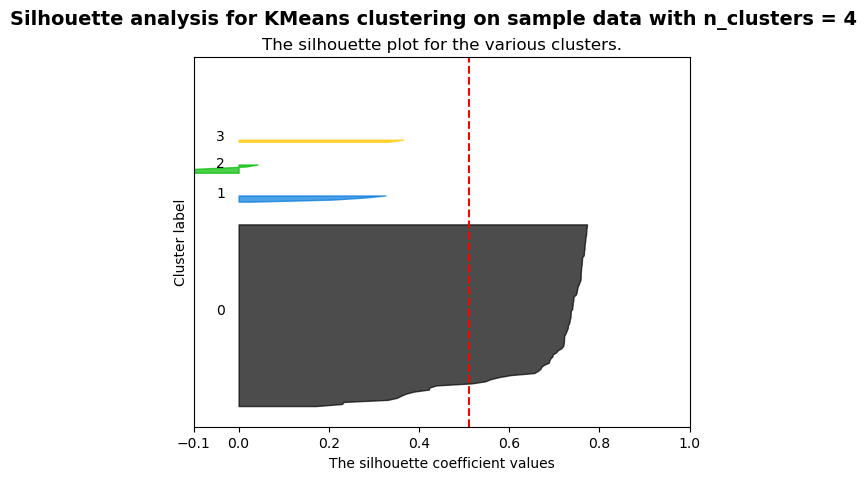

In [23]:
n_clusters = 4

fig= plt.figure()
ax = fig.add_subplot()

# The 1st subplot is the silhouette plot
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_rocket) + (n_clusters + 1) * 10])

cluster_labels = kmodel[n_clusters].fit_predict(X_rocket)
    
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_rocket, cluster_labels)
print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg,)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_rocket, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7,)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for {kmodel[n_clusters].__class__.__name__} clustering on sample data with n_clusters = {n_clusters}",fontsize=14,fontweight="bold")

plt.show()

The silhouette score above indicates that the data points are bordering clusters and that the distance between the clusters is not as significant. The plot above shows the coefficient values for the samples in each cluster. A majority of the samples in cluster 3 are above 0.5 which means that they are clustered very well. Conversely, in clusters 1 and 0, there are negative points that indicate that the samples may be in the wrong cluster.

## Davies-Bouldin Index
Davies-Boulding Index (DBI) evaluates the performance of a clustering algorithm by measuring the average similarity of each cluster by comparing the distance between clusters to the size of the clusters. A lower DBI indicates that the clustering has better separation between the clusters. A higher value indicates that the groupings are not that well separated and could potentially lead to overlap in clusters. The average similarity is defined as:

$$
    DB = \frac{1}{N}\sum^N_{i=1}\max_{j\neq i}(\frac{s_i+s_j}{d_{ij}})
$$
where $N$ is the number of clusters, $s$ is the average within cluster distance, and $d$ is the between cluster distance of cluster $i$ and $j$. Further details of the DBI implementation can be found [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4766909). We can calculate the DBI for various numbers of clusters or clustering algorithms to determine the best solution. We can plot the DBI for various clusters and identify the elbow point.

In [24]:
from sklearn.metrics import davies_bouldin_score

In [25]:
clusters = range(2, 10)
kmodel = [KMeans(n_clusters=i) for i in clusters]
score_db = [davies_bouldin_score(X_rocket,kmodel[i].fit(X_rocket).predict(X_rocket)) for i in range(len(kmodel))]

C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

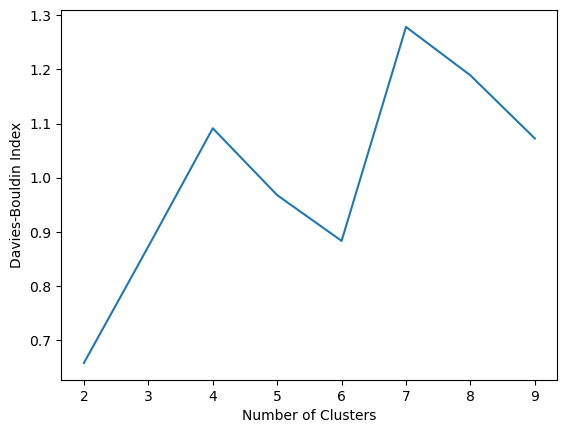

In [26]:
plt.plot(clusters,score_db)
plt.ylabel('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.show()

In the plot above, we can see that the lowest Davies-Bouldin value is 2 clusters suggesting that 2 clusters may be optimal but this decision can vary based on visual and cluster interpretation.

# Citations
1) Scott M. Lundberg and Su-In Lee. 2017. A unified approach to interpreting model predictions. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 4768–4777.
2) Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin. 2016. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 1135–1144. https://doi.org/10.1145/2939672.2939778
3) Jolliffe, I. T. Principal Component Analysis. 2nd ed., Springer, 2002.
4) Tenenbaum, J.B.; De Silva, V.; & Langford, J.C., “A global geometric framework for nonlinear dimensionality reduction,” Science 290 (5500)
5) Borg, I.; Groenen P., “Modern Multidimensional Scaling - Theory and Applications,” Springer Series in Statistics (1997)
6) “Web Scale K-Means clustering” D. Sculley, Proceedings of the 19th international conference on World wide web (2010)
7) M. Belkin and P. Niyogi, "Laplacian Eigenmaps for Dimensionality Reduction and Data Representation," in Neural Computation, vol. 15, no. 6, pp. 1373-1396, 1 June 2003, doi: 10.1162/089976603321780317.
8) Davies, David L.; Bouldin, Donald W. (1979). “A Cluster Separation Measure”. IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224-227
9) L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.
10) van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research, 9(86), 2579–2605. Retrieved from http://jmlr.org/papers/v9/vandermaaten08a.html
11) Simonyan, K., Vedaldi, A., & Zisserman, A. (2014). Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps. arXiv [Cs.CV]. Retrieved from http://arxiv.org/abs/1312.6034